# **Préliminaires**

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/navires-2022-a-la-mano/ships.tgz


In [2]:
import tensorflow as tf

SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
!tar xzf /kaggle/input/navires-2022-a-la-mano/ships.tgz

# **Lecture des images & présentation des données**
* Séparation des images en deux sets : un dataset de training pour le réseau de neurones, ainsi qu'un set de test pour tester la véracité du modèle d'entrainement
* Visualisation de la répartition du jeu de données entre les classes
* Mise en évidence du type d'images avec lesquelles le réseau de neurones travaille

In [4]:
# ------------- Set de données d'entrainement -------------
data_train = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/ships32",
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(32, 32),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)


# ------------- Set de données de validation -------------
data_test = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/ships32",
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(32, 32),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 51284 files belonging to 13 classes.
Using 41028 files for training.


2022-07-10 00:44:51.467577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 00:44:51.568352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 00:44:51.569094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 00:44:51.571830: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 51284 files belonging to 13 classes.
Using 10256 files for validation.


Liste des classes et leur représentation dans le dataset :

[('destroyer', 6860), ('containership', 6813), ('cruiser', 6811), ('methanier', 3511), ('ferry', 3499), ('tug', 3457), ('coastguard', 3451), ('vsmallfish', 3396), ('smallfish', 3356), ('corvette', 3151), ('submarine', 3058), ('cv', 2150), ('sailing', 1771)]


Liste des labels :

['destroyer', 'containership', 'cruiser', 'methanier', 'ferry', 'tug', 'coastguard', 'vsmallfish', 'smallfish', 'corvette', 'submarine', 'cv', 'sailing']




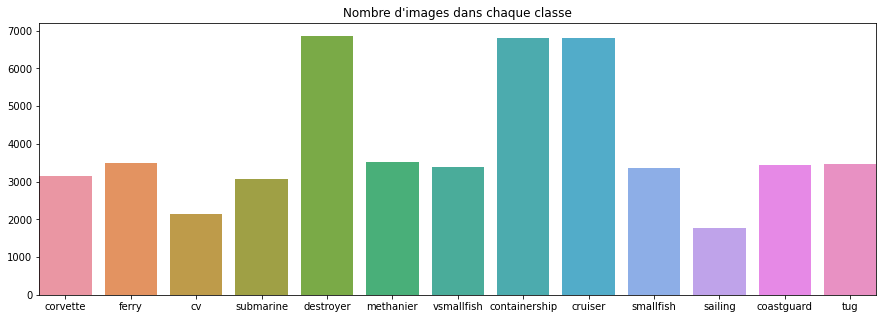

In [5]:
path = '/kaggle/working/ships32'
classes = os.listdir(path)
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))


# ------------- Liste des classes et leur représentation dans le dataset -------------
classes_and_number = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:13]
print("Liste des classes et leur représentation dans le dataset :\n")
print(classes_and_number)
print("\n")


# ------------- Liste des labels -------------
labels = [i[0] for i in classes_and_number]
print("Liste des labels :\n")
print(labels)
print("\n")


# ------------- Plotting du nombre d'images dans chaque classe -------------
Y = []
for c in classes:
    if c in labels:
        dir_path = os.path.join(path, c)
        label = labels.index(c)
        for i in os.listdir(dir_path):
            image = cv.imread(os.path.join(dir_path, i))   
            try:
                resized = cv.resize(image, (32, 32))
                Y.append(label)
            except:
                print(os.path.join(dir_path, i), "[ERROR] can't read the file")
                continue

obj = Counter(Y)

fig = plt.figure(figsize = (15, 5))
sns.barplot(x = [labels[i] for i in obj.keys()], y = list(obj.values())).set_title("Nombre d'images dans chaque classe")
plt.margins(x = 0)
plt.show()

Exemples aléatoires d'images contenues dans le pool d'entrainement du réseau de neurones :



2022-07-10 00:44:58.961710: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


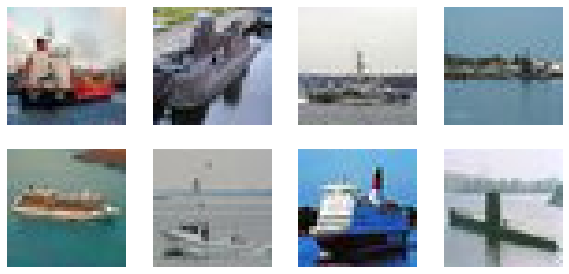

In [6]:
# ------------- Visualisation d'images aléatoires du set de données -------------
data_train.take(1)

print("Exemples aléatoires d'images contenues dans le pool d'entrainement du réseau de neurones :\n")
plt.figure(figsize=(10, 10))
for images, l in data_train.take(1):
    for i in range(8):
        rand_num = np.random.randint(0, 50000)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

# **Augmentation des données**
Les images d'entrée vont être modifiées de manière à perturber le réseau de neurones concernant la classification des données. Cela rend l'entrainement plus complet et fiable.
En l'occurrence ici, les données sont modifiées de la manière suivante :
1. Retournement de l'image à l'horizontale
2. Modification du contraste de l'image
3. Rotation aléatoire de l'image

Ensuite, on ajoute des poids sur les données. Les 13 classes de bateaux à classifier sont inégales concernant le nombre d'image qu'elles contiennent, il faut donc l'indiquer au réseau de neurones pour qu'il puisse le prendre en compte dans son entrainement. Pour cela, on donne à chaque classe un coefficient de représentation au sein du dataset complet.

In [7]:
# ------------- classes de données -------------
nb_classes = 13


# ------------- data augmentation -------------
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling, Layer, BatchNormalization

flip = Sequential(
    [
        layers.RandomFlip("horizontal"),
    ]
)
rot = Sequential(
    [
        layers.RandomRotation(0.5),
    ]
)

augmented_rot = data_train.map(
  lambda x, y: (rot(x, training=True), y))

augmented_flip = data_train.map(
  lambda x, y: (flip(x, training=True), y))

augmented_train_ds = data_train.concatenate(augmented_flip).concatenate(augmented_rot)


# ------------- Ajout du poids sur chaque type de données -------------
count = !cd ships32; for elt in $(ls); do ls $elt | wc -l; done
labels = !cd ships32; for elt in $(ls); do echo $elt; done

count = [int (i) for i in count]
coeff = {}

for i in range(len(count)):
    coeff[i] = float("{:.2f}".format(count[i] / sum(count)))

# **Création du réseau de neurones**
Ici, on décide comment les différentes couches du réseau de neurones seront agencées pour traiter les données. 
1. On choisit des couches de convolution allant de 32 à 128, que l'on double
2. On normalise le Batch de données après chaque couche de convolution pour mieux coordonner les changements entre chaque couche convolutive
3. On ajoute un MaxPooling une couche convolutive sur deux pour sous-échantillonner l'image lors de sa classification
4. On ajoute une couche Dropout pour réduire l'over-fitting du modèle, c'est-à-dire qu'on supprime des neurones dans la couche actuelle.
5. On Flatten et on Dense pour donner la bonne sortie d'image après être passé dans le modèle.
6. On ajoute un EarlyStopping pour éviter que le modèle ne sur-apprenne les images d'entrainement.

Il est bon de noter que le learning rate de l'optimiseur est important, et qu'un learning rate petit permet de rentre l'accuracy entre les epoch plus stable. On choisit donc un learning rate de 0,0001.

In [8]:
# ------------- Modèle d'entrainement -------------
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Sequential()
model.add(Rescaling(1./255))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))


model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())


model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))


model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=2, mode='auto')
fit = model.fit(augmented_train_ds, validation_data=data_test, epochs=100, class_weight = coeff)

print("Nombre de couches : ", len(model.layers))

Epoch 1/100


2022-07-10 00:45:02.505050: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3849/3849 [==============================] - 51s 11ms/step - loss: 0.2030 - accuracy: 0.2891 - val_loss: 1.8429 - val_accuracy: 0.4065
Epoch 2/100
3849/3849 [==============================] - 42s 11ms/step - loss: 0.1441 - accuracy: 0.3990 - val_loss: 1.6511 - val_accuracy: 0.4592
Epoch 3/100
3849/3849 [==============================] - 42s 11ms/step - loss: 0.1236 - accuracy: 0.4630 - val_loss: 1.4697 - val_accuracy: 0.5181
Epoch 4/100
3849/3849 [==============================] - 43s 11ms/step - loss: 0.1118 - accuracy: 0.5064 - val_loss: 1.3555 - val_accuracy: 0.5618
Epoch 5/100
3849/3849 [==============================] - 44s 11ms/step - loss: 0.1034 - accuracy: 0.5396 - val_loss: 1.3227 - val_accuracy: 0.5688
Epoch 6/100
3849/3849 [==============================] - 44s 11ms/step - loss: 0.0975 - accuracy: 0.5623 - val_loss: 1.1632 - val_accuracy: 0.6092
Epoch 7/100
3849/3849 [==============================] - 44s 11ms/step - loss: 0.0932 - accuracy: 0.5803 - val_loss: 1.1273 - val_

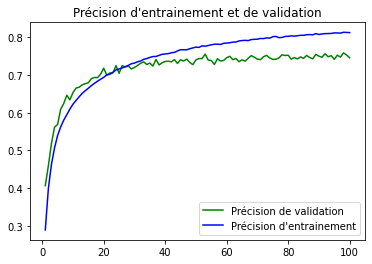

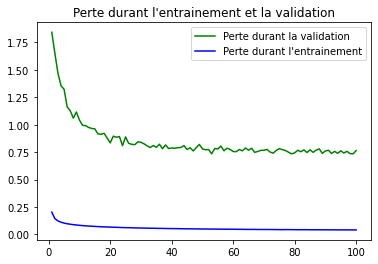

3849/3849 [==============================] - 28s 7ms/step - loss: 0.5465 - accuracy: 0.8319
Précision du modèle de test :  83.19 %


In [9]:
# ------------- Plot des accuracy de training et de validation sur 100 epoch -------------
def training_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, val_acc, 'g', label="Précision de validation")
    plt.plot(epochs, acc, 'b', label="Précision d'entrainement")
    plt.title("Précision d'entrainement et de validation")
    plt.legend()
    plt.figure()
    plt.plot(epochs, val_loss, 'g', label="Perte durant la validation")
    plt.plot(epochs, loss, 'b', label="Perte durant l'entrainement")
    plt.title("Perte durant l'entrainement et la validation")
    plt.legend()
    plt.show()

training_plot(fit)
score_test = model.evaluate(augmented_train_ds)
nombre = score_test[1]*100
print('Précision du modèle de test : {0:6.2f} %'.format(nombre))

## **Interprétations :**
* **Courbe de précision :** La précision du modèle est assez satisfaisante dans l'ensemble. La courbe ne fait que croître, témoignant d'un overfitting absent ou très léger (sinon, la courbe retomberait sur la fin de l'entrainement). La précision de validation et d'entrainement converge brutalement à certains moments. Néanmoins, le modèle parait relativement efficace.

* **Courbe de perte :** Les pertes générées durant l'entrainement du réseau de neurones et durant sa validation tend vers 0 au fur et à mesure des epoch. La courbe d'entrainement est relativement stable, bien que sa variation soit très faible. Cela témoigne d'un learning rate assez faible. On peut également interpréter ça comme le résultat d'un modèle qui underfit. Pour régler ce souci, deux solutions sont possibles :
    1. Ajouter plus de modifications sur les données d'entrainement pour rendre les données plus difficiles à interpréter
    2. Réguler le modèle en l'obligeant à se concentrer sur les motifs répétitifs qu'il rencontre pour mieux généraliser, ou au contraire le réduire la régularisation du modèle
    3. Augmenter la compléxité du modèle

Matrice de confusion brute :
[[ 407    4   12   16    3   68   29    1    3   69    3   29   71]
 [   2 1234    2   19    2   11   18   21    1   14    5    9   29]
 [  49    1  220    9    9  263   20    0    1   26    6    7   17]
 [   3    3    0 1345    2    9   25    0    3    6    2    2    8]
 [  10    4    8   19  206  120   11    2    3   11   11    3   14]
 [  16    5   31   12    9 1186   11    1    5   20   15    8   19]
 [  26    7    0   64    1   18  521    5    0   27    1    9   31]
 [   5   42    0    7    0    5   43  521    0   15    1   16   32]
 [   6    3    0   22    0   17    8    2  252   23    8    5   28]
 [  16    1    0    4    0    9    7    0    0  465    2   17  166]
 [  12    8    9   14    3   58    6    0    3   12  406    8   32]
 [  18    3    1    3    1   12   10    2    1   48    1  542   53]
 [  20    5    3   14    0   14   12    0    0  227    7    9  343]]




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


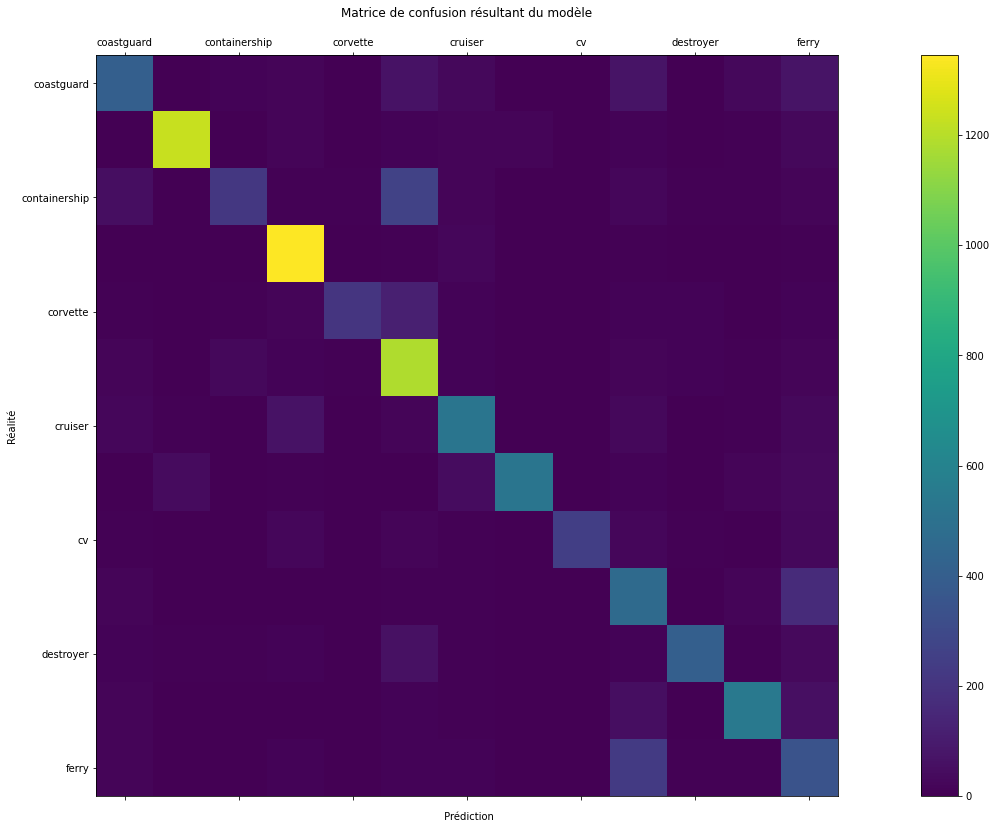

In [10]:
from sklearn.metrics import confusion_matrix
from numpy import argmax


# ------------- Calculs préliminaires -------------
y_true = []
y_pred = []
for x, y in data_test:
    y = tf.argmax(y, axis = 1)
    y_true.append(y)
    y_pred.append(tf.argmax(model.predict(x), axis = 1))

y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)


# ------------- Matrice de confusion -------------
cm = confusion_matrix(y_true, y_pred)

print("Matrice de confusion brute :")
print(cm)
print("\n")

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Matrice de confusion')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('\n Prédiction')
plt.ylabel('Réalité')
plt.title("Matrice de confusion résultant du modèle\n")
plt.show()

In [11]:
#  ------------- Rapport de classification -------------
from sklearn.metrics import classification_report

print("Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=2))

Rapport de classification :

               precision    recall  f1-score   support

     corvette       0.69      0.57      0.62       715
        ferry       0.93      0.90      0.92      1367
           cv       0.77      0.35      0.48       628
    submarine       0.87      0.96      0.91      1408
    destroyer       0.87      0.49      0.63       422
    methanier       0.66      0.89      0.76      1338
   vsmallfish       0.72      0.73      0.73       710
containership       0.94      0.76      0.84       687
      cruiser       0.93      0.67      0.78       374
    smallfish       0.48      0.68      0.56       687
      sailing       0.87      0.71      0.78       571
   coastguard       0.82      0.78      0.80       695
          tug       0.41      0.52      0.46       654

     accuracy                           0.75     10256
    macro avg       0.77      0.69      0.71     10256
 weighted avg       0.77      0.75      0.74     10256



## **Interprétations de la matrice de confusion et du rapport de classification :**

Visuellement parlant, la matrice de confusion montre que le modèle reconnait relativement bien les différents types de bateaux. On retrouve une coloration plus prononcée sur sa diagonale, c'est à dire qu'entre la prédiction et la réalité, le modèle arrive la majorité du temps à classifier les images correctement. Cependant, la coloration jaune / vert, qui indique les plus gros taux de reconnaissance, sont localisés pour seulement 3 des 13 types de bateaux. 

En comparant la pool d'images pour chaque type de bateaux, on pourrait s'attendre à ce que le modèle reconnaisse plus facilement les 3 types les plus représentés, à savoir les *destroyers*, les *cruisers* et les *containerships*. Cependant, en analysant le rapport de classification, on s'aperçoit que non.
    On remarque aussi, via la matrice de confusion, que le modèle a tendance à attribuer l'étiquette *containership* ou *ferry* à d'autres types de bateau.

Il pourrait être plus simple pour le modèle de mieux reconnaître le type de certains bateaux avec des images d'entrainement et de test plus grandes, donc plus nettes. Des images 32x32 donnent parfois l'impression de perdre de l'information précise et importante pour une meilleure détection des bateaux.

# **Résultats à soumettre**

In [12]:
X_test = np.load('/kaggle/working/ships_competition.npz', allow_pickle=True)['X']
X_test = X_test.astype('float32') #/ 255


res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="Id")

In [13]:
!head reco_nav.csv

Id,Category
0,5
1,5
2,1
3,11
4,9
5,5
6,5
7,5
8,7


In [14]:
import os

# ------------- Génération du fichier de rendu Leaderboard -------------
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv

In [15]:
!rm -rf ships32/

### **AUTHORS**
* Sébastien Barbier
* Laure Marcheron

Projet IREN - Promotion 2023